In [21]:
import pandas as pd
import numpy as np
import os, copy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### define functions

In [51]:
# np inter quantile range
def iqr(x,axis=0):
    return np.nanpercentile(x, 75, axis=axis) - np.nanpercentile(x, 25, axis=axis)

# BLAND-ALTMAN plot for technical replicates
def bland_altman_plot(data1, data2,xlabs=True,ylabs=True,ymin=-10,ymax=10,xmin=-10,xmax=5):
    median = np.nanmedian([data1, data2], axis=0)
    diff = data1 - data2
    md = np.nanmedian(diff)
    sd = np.nanpercentile(diff, 75) - np.nanpercentile(diff, 25)
    plt.axhline(md, color='k', linestyle='--')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    plt.scatter(median, diff, alpha=0.5,marker='.',c='dimgray',rasterized=True)
    if xlabs:
        plt.xlabel('Median (<R1,R2>)')
    if ylabs:
        plt.ylabel(r'$\Delta $ (R1-R2)')
    plt.ylim(ymin,ymax)
    plt.xlim(xmin,xmax)

# # fill nan with linear interpolation
def fill_nan_with_interpolation(arr):
    nans = np.isnan(arr)
    if np.all(nans):
        return arr  # return if all values are NaN
    x = np.arange(len(arr))
    f = interp1d(x[~nans], arr[~nans], kind=1, bounds_error=False, fill_value="extrapolate") # simple linear interpolation
    return f(x)

def clean_row(row, replt_log_thr=1, min_fract=0.75, split_morn_aft=None): # this does the cleaning of every single compound
    row_clean = []
    for i in range(1, len(row), 2):
        diff = np.abs(row[i] - row[i-1]) # absolute difference of each technical replicate pair
        if diff > replt_log_thr: # set to NaN if difference is above threshold
            row_clean.append(np.nan)
        else: # otherwise take the mean of the two replicates
            row_clean.append(np.mean(row[i-1:i+1]))
    if split_morn_aft is not None:
        if np.mean(~np.isnan(row_clean[:split_morn_aft])) < min_fract or np.mean(~np.isnan(row_clean[split_morn_aft:])) < min_fract: # check both morning and afternoon have at least min_fract non-NaN values
            return np.array([np.nan]*len(row_clean))
    else:
        if np.mean(~np.isnan(row_clean)) < min_fract: # check entire day has at least min_fract non-NaN values
            return np.array([np.nan]*len(row_clean))
    return np.array(row_clean)

def anim_comps_speed(X, y, title='', pos=0):
    plt.subplot(2, 3, 1 + pos)
    plt.imshow(X, aspect='auto', cmap='viridis',vmin=-2.3, vmax=2.3, rasterized=True)
    plt.xticks([0,12,24,36,48,60],[0,90,180,270,360,450])
    if title[-1] == '1':
        plt.ylabel('Compounds')
    plt.xlim(0,len(y))
    # remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.subplot(4, 3, 7 + pos)
    plt.plot(y,c='k')
    plt.ylim(0.67, 3.4)
    plt.xticks([0,12,24,36,48,60],[0,90,180,270,360,450])
    plt.xlabel('Time (minutes)')
    if title[-1] == '1':
        plt.ylabel('Avg. Speed (cm/sec)')
    plt.xlim(0,len(y))
    # remove spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)


# Load and clean LCMS data


## Supplementary Figure 3B

c:\Users\dennise\AppData\Local\miniforge3\envs\microdialysis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


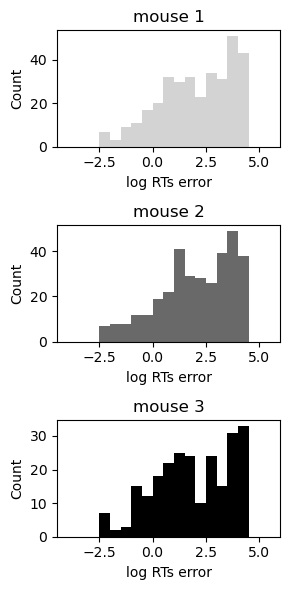

In [23]:
# import RTs.csv as a dataframe
data = pd.read_csv('../../data/raw/lcms/RTs.csv', header=None)
# turn nans into zeros
# merge first and second column, both are animal 1
data.loc[:,0] = data.loc[:,0].add(data.loc[:,1],fill_value=0)
data = data.drop(columns=[1])
# plot three histograms of the RTs in the dataframe
plt.figure(figsize=(3, 6))
plt.subplot(311)
plt.hist(np.log(data.loc[:,0]), bins=np.arange(-4, 6, 0.5), color='lightgrey')
plt.title('mouse 1')
plt.xlabel('log RTs error')
plt.ylabel('Count')
plt.subplot(312)
plt.hist(np.log(data.loc[:,2]), bins=np.arange(-4, 6, 0.5), color='dimgrey')
plt.xlabel('log RTs error')
plt.ylabel('Count')
plt.title('mouse 2')
plt.subplot(313)
plt.hist(np.log(data.loc[:,3]), bins=np.arange(-4, 6, 0.5), color='black')
plt.xlabel('log RTs error')
plt.ylabel('Count')
plt.title('mouse 3')
plt.tight_layout()
plt.savefig('../../figures/supp/S3B_RTs_histogram.eps', dpi=600)

## LCMS data

In [24]:
# load LCMS data
lcms_dir = '../../data/raw/lcms/'
lcms_files = [f for f in os.listdir(lcms_dir) if f.startswith('dansyl')]
print(lcms_files)
# read data
dfs = [pd.read_csv(os.path.join(lcms_dir, f)) for f in lcms_files]

['dansyl_peak_pairs_mouse1.csv', 'dansyl_peak_pairs_mouse2.csv', 'dansyl_peak_pairs_mouse3.csv']


In [25]:
# get the total identified compounds
for df in dfs:
    print(len(df[df["Identification Level"]!='Unidentified']))

1069
1471
1376


In [26]:
## Step 1: select compounds with high confidence identification (only Tier 1 & 2)
tier_dfs = [df[(df["Identification Level"] == "Tier 1") | (df["Identification Level"] == "Tier 2")].copy() for df in dfs]
# merge compound names of last dataset
dfs[2]['Compound'] = dfs[2]['Compound'].fillna(dfs[2]['Compound.1'])
tier_dfs[2]['Compound'] = tier_dfs[2]['Compound'].fillna(tier_dfs[2]['Compound.1'])
# extract compounds names
compounds = [df["Compound"].tolist() for df in tier_dfs]
print('Number of individual, Tier 1&2 compounds per animal: ', [len(c) for c in compounds])


Number of individual, Tier 1&2 compounds per animal:  [241, 343, 345]


In [27]:
# find intersection of compounds in all 3 datasets
common_comps = list(set(compounds[0]).intersection(set(compounds[1])).intersection(set(compounds[2])))
common_comps.sort()
# find the group of total compounds -- union
union_comps = list(set(compounds[0]).union(set(compounds[1])).union(set(compounds[2])))
# order union compounds -- put common compounds first, the rest after
union_comps = common_comps + [comp for comp in union_comps if comp not in common_comps]
print('Number of total, Tier 1&2 compounds (union): ', len(union_comps))
# order datasets according to union comp
data_order_prelog = []
for i in range(3):
    data_order_prelog.append(dfs[i][dfs[i]['Compound'].isin(union_comps)].copy())
    data_order_prelog[i] = data_order_prelog[i].set_index('Compound').reindex(union_comps).reset_index() # here we do the reordering
    # if not in Tier 1 or Tier 2, set to NaN
    data_order_prelog[i].loc[~data_order_prelog[i]['Compound'].isin(compounds[i]), data_order_prelog[i].columns != 'Compound'] = np.nan

Number of total, Tier 1&2 compounds (union):  482


In [28]:
# preprocessing steps
log_transform = True
metadata_order = [d.iloc[:,:21] for d in data_order_prelog]
data_order_prenan=copy.deepcopy(data_order_prelog)


In [29]:

# data_order_order extraction and columns renaming (specific for data_orderset of mouse 1)
''' note to describe the sampling/naming procedure
the experiment name (2025624_MN_619v1_) preceeds all tube names (e.g. A2_)
the last two digits indicate which replicate number: 
A2_01 and A2_02 are the same sample/time point, two technical replicates
'''
data_order_prenan[0] = copy.deepcopy(data_order_prelog[0].iloc[:,21:-4])
if log_transform:
    data_order_prenan[0] = data_order_prenan[0].transform(lambda x: np.log2(x))
new_columns = []
tubenames=[]
sampleno=-1

for col in data_order_prenan[0].columns:
    name = col.split('2025624_MN_619v1_')[1]
    if name.split('_')[0] not in tubenames:
        sampleno+=1
        tubenames.append(name.split('_')[0])
    newname='{:02d}_{}'.format(sampleno,name.split('_')[1])
    new_columns.append(newname)
data_order_prenan[0].columns = new_columns

In [30]:
# columns renaming (specific for data_orderset of mouse 2)
''' note to describe the sampling/naming procedure:
A = the first sample, A.1 is the replicate of A
A.2 is the second sample, A.3 is the replicate of A.2
A.4 is the third sample, A.5 is the replicate of A.4...
B = the 13th sample, B.1 is the replicate of the 13th sample/time bin... etc.
'''
data_order_prenan[1] = copy.deepcopy(data_order_prelog[1].iloc[:,21:-3])
if log_transform:
    data_order_prenan[1] = data_order_prenan[1].transform(lambda x: np.log2(x))
new_columns = []
sampleno=-1

for col in data_order_prenan[1].columns:
    parts = col.split('.')
    if len(parts) >= 2:
        if int(parts[1])%2==0:
            # this is the first of two technical replicates
            sampleno+=1
            new_col = "{:02d}_01".format(sampleno)  # Default to _01 if first of its letter
        else:
            new_col= "{:02d}_02".format(sampleno)
    else:
        sampleno+=1
        new_col = "{:02d}_01".format(sampleno)  # Default to _01 if first of its letter
    new_columns.append(new_col)
data_order_prenan[1].columns = new_columns


In [31]:

# columns renaming (specific for data_orderset of mouse 3)
''' note to describe the sampling/naming procedure:
Mor and Aft refer to morning and afternoon
Mor = first sample
Mor.1 = second sample...
Aft = first sample after the break
Aft.1 = second sample after the break...
'''
data_order_prenan[2] = copy.deepcopy(data_order_prelog[2].iloc[:, 24:-3])
if log_transform:
    data_order_prenan[2] = data_order_prenan[2].transform(lambda x: np.log2(x))
new_columns = []
for icol in np.arange(0,data_order_prenan[2].shape[1],2):
    new_columns.append("{:02d}_01".format(int(icol/2)+1))
    new_columns.append("{:02d}_02".format(int(icol/2)+1))
data_order_prenan[2].columns = new_columns

In [32]:
# # hstack data
alldata = np.hstack(data_order_prenan)

Text(0.5, 1.0, 'Median Intensities of Samples with Bounds')

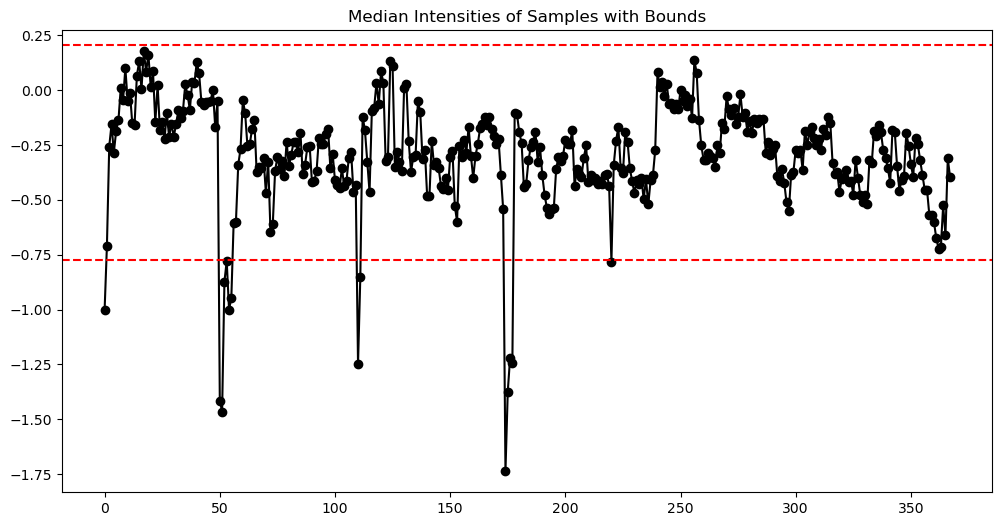

In [33]:
# check for columns with abnormally high or low values across all datasets
# --> remove samples with intensities out of bounds (median ± 4×MAD)
median_intensities = np.nanmedian(np.nanmedian(alldata,axis=0))
mad_intensities = np.nanmedian(np.abs(np.nanmedian(alldata,axis=0) - median_intensities))
lower_bound = median_intensities - 4 * mad_intensities
# plot median intensities of each sample
plt.figure(figsize=(12, 6))
plt.plot(np.nanmedian(alldata, axis=0), marker='o', linestyle='-', color='k')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axhline(y=median_intensities + 4 * mad_intensities, color='r', linestyle='--', label='Upper Bound')
plt.title('Median Intensities of Samples with Bounds')

In [ ]:
# set columns below lower bound to NaN
data_order = copy.deepcopy(data_order_prenan)
mouse=0

for d in data_order:
    mouse+=1
    print('on mouse: {}'.format(mouse))
    for col in d.columns:
        if d[col].median() < lower_bound:
            d[col] = np.nan
            print(col)
# two samples had a single replicate dropped. dropping the other replicate
data_order[0]['00_02']=np.nan
data_order[2]['55_02']=np.nan

on mouse: 1
00_01
25_01
25_02
26_01
26_02
27_01
27_02
on mouse: 2
00_01
00_02
32_01
32_02
33_01
33_02
55_01
on mouse: 3


## Supplementary Figure 3C

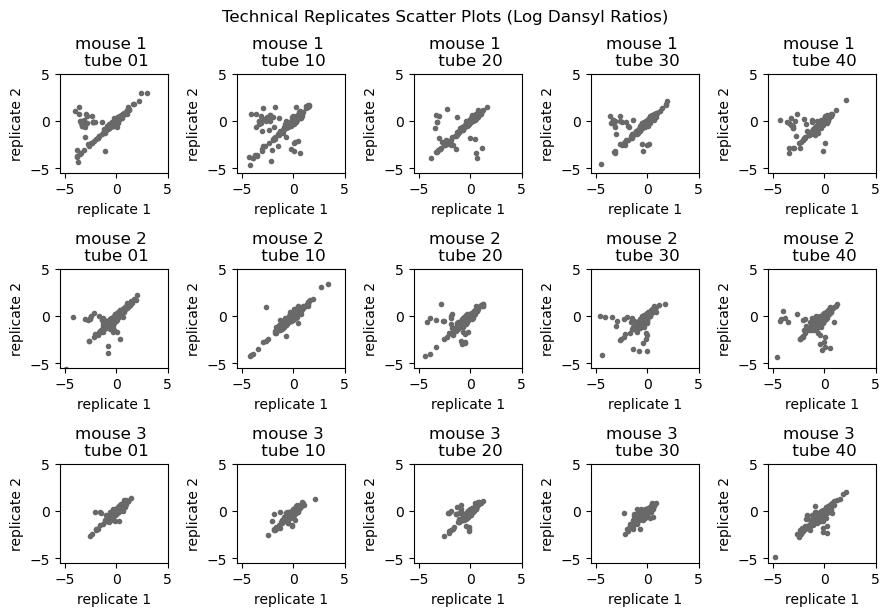

In [49]:
# check technical replicates -- plot scatter plots showing correlation between replicates
# pick a few examples
examples=['01', '10', '20', '30', '40']
plt.figure(figsize=(9, 6))
for id, d in enumerate(data_order):
    for icol, col in enumerate(examples):
        plt.subplot(3,5,5*id + icol+1)
        plt.scatter(d[col+'_01'], d[col+'_02'],marker='.',c='dimgrey',rasterized=True)
        plt.title(f'mouse {id+1} \n tube {col}')
        plt.xlabel('replicate 1')
        plt.ylabel('replicate 2')
        plt.xlim(-5.5,5)
        plt.ylim(-5.5,5)
plt.tight_layout()
plt.suptitle('Technical Replicates Scatter Plots (Log Dansyl Ratios)', y=1.02)
plt.savefig('../../figures/supp/S3C_technical_replicates_scatter_plots.eps',dpi=600)
plt.show()

## Supplementary Figure 3D

C:\Users\dennise\AppData\Local\Temp\ipykernel_33556\786544341.py:7: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian([data1, data2], axis=0)


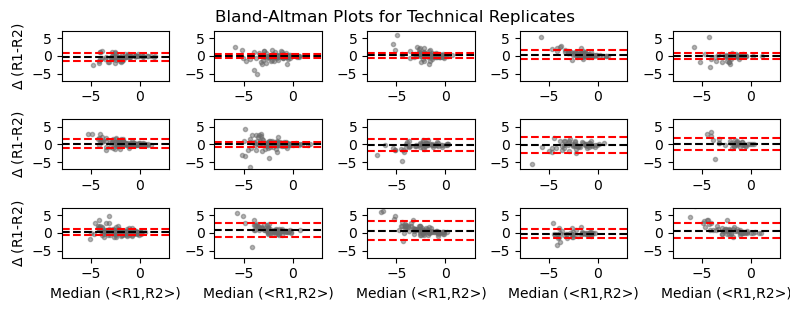

In [55]:
# same examples as above
plt.figure(figsize=(8, 3))
for id, d in enumerate(data_order):
    for icol, col in enumerate(examples):
        plt.subplot(3,5,5*id + icol+1)
        if icol%5==0:
            ylabs=True
        else:
            ylabs=False
        if id==2:
            xlabs=True
        else:
            xlabs=False
        xs=np.log2(d[col+'_01'])
        ys=np.log2(d[col+'_02'])
        bland_altman_plot(xs, ys,xlabs,ylabs,ymin=-7,ymax=7,xmin=-8,xmax=3)
plt.tight_layout()
plt.suptitle('Bland-Altman Plots for Technical Replicates', y=1.02)
plt.savefig('../../figures/supp/S3D_bland_altman_plots.eps',dpi=600)
plt.show()

In [56]:
# remove dirty technical replicates (based on log2 fold change threshold) 
# and minimum fraction of good replicates per compound (75%)

clean_data = []
for id, d in enumerate(data_order): # do the cleaning individiually for each animal dataset
    clean_data.append([])
    for i in range(d.shape[0]):
        clean_data[id].append(clean_row(d.iloc[i,:].values, replt_log_thr=1, min_fract=0.75, split_morn_aft=[26,32,None][id])) # specify split points for morning and afternoon for each dataset
    clean_data[id] = np.array(clean_data[id])

# reduce intersection set to compounds with >75% non-NaN values in all datasets
good_comps = [np.nanmean(np.isnan(clean_data[i]),1) < 0.25 for i in range(3)]
# find common compounds that are good in all datasets
common_comps_good_idx = np.where(np.sum(good_comps, 0)[:len(common_comps)] == 3)[0]
# next, refine union compounds  to avoid compounds that have nans everywhere
union_comps_good_idx = np.where(np.sum(good_comps,0) > 0)[0]
# set subtract common compounds from union
union_minus_common = [idx for idx in union_comps_good_idx if idx not in common_comps_good_idx]
# final union of good compounds
union_comps_good_idx = np.concatenate([common_comps_good_idx, np.array(union_minus_common)])
# get common compound names
common_compound_names = [common_comps[i] for i in common_comps_good_idx]
# # move the good compounds to the top of each dataset
clean_data_good = [d[union_comps_good_idx,:] for d in clean_data]

In [57]:
# for day 1 and day 2, split into morning and afternoon (two separate recording sessions!)
# day 1 
day1_morning = clean_data_good[0][:, :26]
day1_afternoon = clean_data_good[0][:, 26:]
# day 2
day2_morning = clean_data_good[1][:, :32]
day2_afternoon = clean_data_good[1][:, 32:]
# day3
day3 = clean_data_good[2]
# print shapes, all should have 447 total compounds and different numbers of timepoints
day1_morning.shape, day1_afternoon.shape, day2_morning.shape, day2_afternoon.shape, day3.shape

((444, 26), (444, 29), (444, 32), (444, 33), (444, 64))

## Supplementary Figure 4A


C:\Users\dennise\AppData\Local\Temp\ipykernel_33556\3453429505.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.log10(means[i][means[i]>0.1]) for i in np.arange(5)],


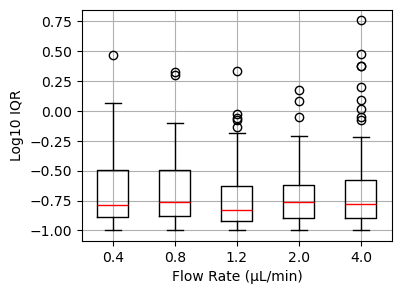

In [ ]:
flowrate_validation = pd.read_csv('../../data/raw/lcms/FlowRateValidationSet.csv')
Tier3 = flowrate_validation['Compound'].isna() * flowrate_validation['Compound.1'].isna()
# select only Tier 1 and Tier 2 compounds (Columns COmpound and COmpound.1 are not nans)
flowrate_validation = flowrate_validation.loc[~Tier3, :]
flowrate_validation.columns[24:54]
flows_cols = [flowrate_validation.columns[i:i+6] for i in np.arange(24, 54, 6)]
flows_data = [flowrate_validation[cols] for cols in flows_cols]


plt.figure(figsize=(4, 3))
means = [iqr(flows_data[i].values, axis=1) for i in np.arange(4, -1, -1)]
plt.boxplot([np.log10(means[i][means[i]>0.1]) for i in np.arange(5)],
            labels=['0.4', '0.8', '1.2', '2.0', '4.0'],medianprops=dict(color='red',linewidth=1))
# plt.ylim(0, 0.5)
plt.xlabel('Flow Rate (µL/min)')
plt.ylabel('Log10 IQR')
# plt.title('Log10 Coefficient of Variation of analyte concentrations\nat different flow rates')
plt.grid(True)
plt.savefig('../../figures/supp/S4A_flow_rate_iqr_validation_boxplot.eps', dpi=300)
plt.show()


## Supplementary Figure 4B



C:\Users\dennise\AppData\Local\Temp\ipykernel_33556\1570221984.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.log10(means[i][means[i]>0.1]) for i in np.arange(5)],


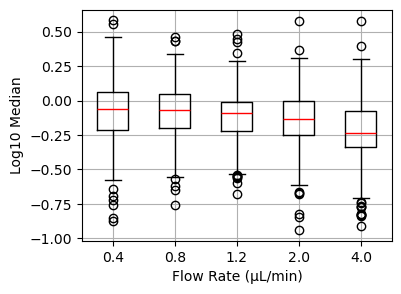

In [ ]:
# plot median
plt.figure(figsize=(4, 3))
medians = [np.nanmedian(flows_data[i].values, axis=1) for i in np.arange(4, -1, -1)]
plt.boxplot([np.log10(medians[i][medians[i]>0.1]) for i in np.arange(5)],
            labels=['0.4', '0.8', '1.2', '2.0', '4.0'],medianprops=dict(color='red',linewidth=1))
# plt.ylim(0, 0.5)
plt.xlabel('Flow Rate (µL/min)')
plt.ylabel('Log10 Median')
# plt.title('Log10 Coefficient of Variation of analyte concentrations\nat different flow rates')
plt.grid(True)
plt.savefig('../../figures/supp/S4B_flow_rate_median_validation_boxplot.eps', dpi=600)
plt.show()

# load and bin video tracking data


In [60]:
# load tracking data
video_dir = '../../data/raw/tracked_videos_DLC'
video_files = [f for f in os.listdir(video_dir) if f.endswith('.csv')]
video_files.sort()
print(video_files)
video_dfs = [pd.read_csv(os.path.join(video_dir, f)) for f in video_files]
# turn video_dfs datetime into pandas datetime
for i in range(len(video_dfs)):
    video_dfs[i]['datetime'] = pd.to_datetime(video_dfs[i]['datetime'])
# set speed to Nan where is_moving==False, low likelihood, speed is an outlier (>50 cm/s)
for i in range(len(video_dfs)):
    video_dfs[i].loc[video_dfs[i]['is_moving'] == False, 'speed_cm_s'] = np.nan
    video_dfs[i].loc[video_dfs[i]['is_outlier'] == True, 'speed_cm_s'] = np.nan
    video_dfs[i].loc[video_dfs[i]['neck_likelihood']<0.99, 'speed_cm_s'] = np.nan
    video_dfs[i].loc[video_dfs[i]['speed_cm_s']>50, 'speed_cm_s'] = np.nan


['01_vid_1_tracking_filtered_rolling_median_5fr.csv', '01_vid_2_tracking_filtered_rolling_median_5fr.csv', '01_vid_3_tracking_filtered_rolling_median_5fr.csv', '01_vid_4_tracking_filtered_rolling_median_5fr.csv', '01_vid_5_tracking_filtered_rolling_median_5fr.csv']


## Supplementary Figure 5


C:\Users\dennise\AppData\Local\Temp\ipykernel_33556\2909041614.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\dennise\AppData\Local\Temp\ipykernel_33556\2909041614.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


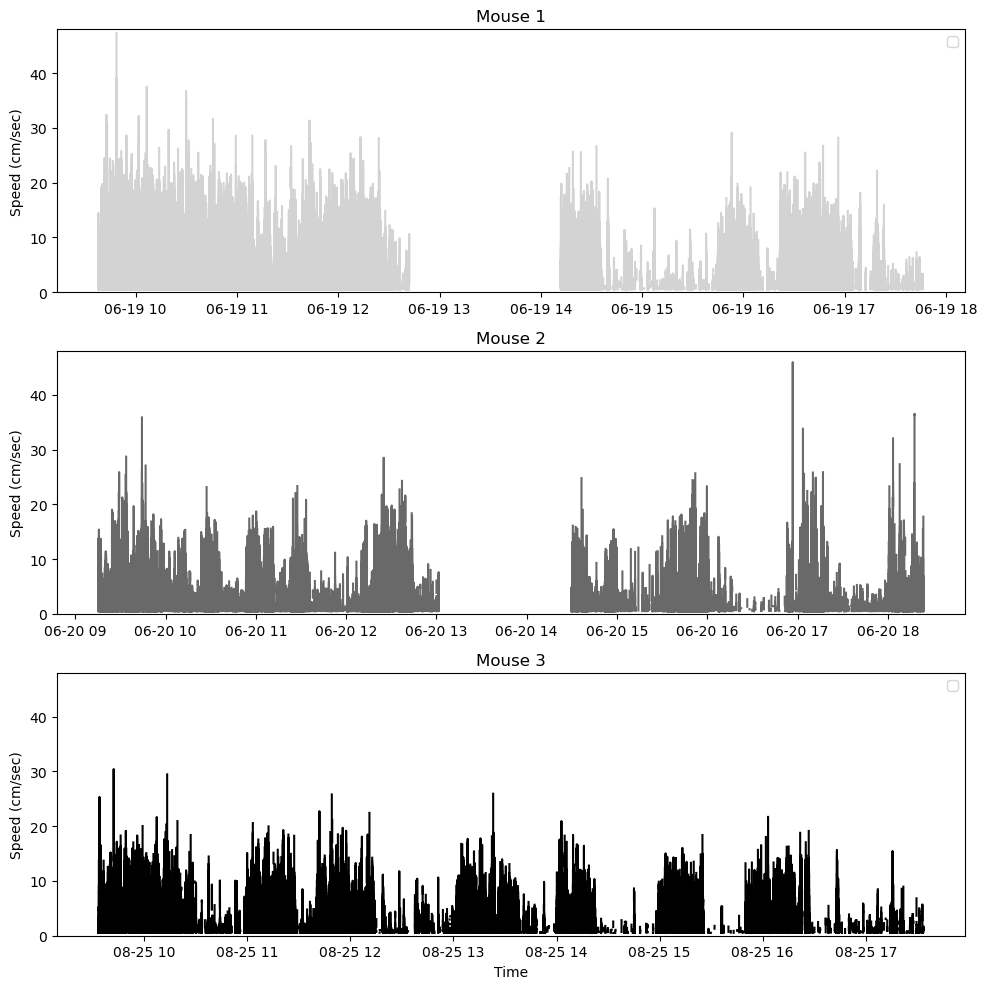

In [62]:

plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.plot(video_dfs[0]['datetime'], video_dfs[0]['speed_cm_s'], color='lightgrey')
plt.plot(video_dfs[1]['datetime'], video_dfs[1]['speed_cm_s'], color='lightgrey')
plt.ylabel('Speed (cm/sec)')
plt.title('Mouse 1')
plt.legend()
plt.ylim(0, 48)

plt.subplot(3,1,2)
plt.plot(video_dfs[2]['datetime'], video_dfs[2]['speed_cm_s'], color='dimgrey')
plt.plot(video_dfs[3]['datetime'], video_dfs[3]['speed_cm_s'], color='dimgrey')
plt.ylabel('Speed (cm/sec)')
plt.title('Mouse 2')
plt.ylim(0, 48)

plt.subplot(3,1,3)
plt.plot(video_dfs[4]['datetime'], video_dfs[4]['speed_cm_s'], color='black')
plt.xlabel('Time')
plt.ylabel('Speed (cm/sec)')
plt.title('Mouse 3')
plt.legend()
plt.ylim(0, 48)
plt.tight_layout()
plt.savefig('../../figures/supp/S5_behavior_speed_all_days_cm_sec.eps',dpi=600)
plt.show()


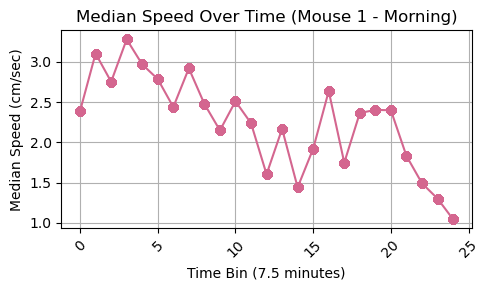

In [63]:
day1_beh_morning = video_dfs[0]
# turn time into seconds
day1_beh_morning['time'] = day1_beh_morning['datetime'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day1_beh_morning['time_bin'] = ((day1_beh_morning['time'] - day1_beh_morning['time'][0]) // 450)
# calculate the mean speed for each bin
day1_beh_morning['median_speed'] = day1_beh_morning.groupby('time_bin')['speed_cm_s'].transform('median')
# plot the median speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day1_beh_morning['time_bin'], day1_beh_morning['median_speed'], marker='o', linestyle='-',c="#D4668F")
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Median Speed (cm/sec)')
plt.title('Median Speed Over Time (Mouse 1 - Morning)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


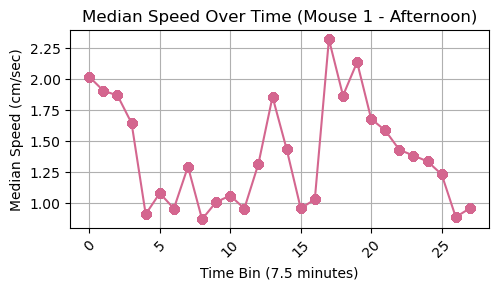

In [64]:
day1_beh_afternoon = video_dfs[1]
day1_beh_afternoon = day1_beh_afternoon[day1_beh_afternoon['datetime'] <= '2025-06-19 17:43:30']
## NOTE: there was a two minutes gap due to a power loss at time 4:06. Remove 4:06 to 4:08. See Notes
day1_beh_postpowerloss = day1_beh_afternoon[day1_beh_afternoon['datetime'] >= '2025-06-19 16:08:00']
day1_beh_postpowerloss.loc[:,'datetime'] = day1_beh_postpowerloss['datetime'] - pd.Timedelta(minutes=2)
# remove two minutes gap
day1_beh_afternoon = pd.concat([day1_beh_afternoon[day1_beh_afternoon['datetime'] < '2025-06-19 16:06:00'],
                                 day1_beh_postpowerloss])
# turn everything into seconds
day1_beh_afternoon['time'] = day1_beh_afternoon['datetime'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day1_beh_afternoon['time_bin'] = ((day1_beh_afternoon['time'] - day1_beh_afternoon['time'][0]) // 450)
# calculate the median speed for each bin
day1_beh_afternoon['median_speed'] = day1_beh_afternoon.groupby('time_bin')['speed_cm_s'].transform('median')
# plot the median speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day1_beh_afternoon['time_bin'], day1_beh_afternoon['median_speed'], marker='o', linestyle='-',c="#D4668F")
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Median Speed (cm/sec)')
plt.title('Median Speed Over Time (Mouse 1 - Afternoon)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


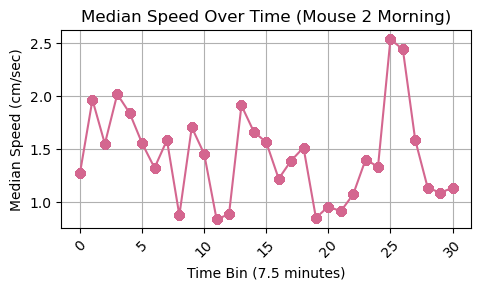

In [65]:
day2_beh_morning = video_dfs[2]
day2_beh_morning['time'] = day2_beh_morning['datetime'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day2_beh_morning['time_bin'] = ((day2_beh_morning['time'] - day2_beh_morning['time'][0]) // 450)
# calculate the median speed for each bin
day2_beh_morning['median_speed'] = day2_beh_morning.groupby('time_bin')['speed_cm_s'].transform('median')
# plot the median speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day2_beh_morning['time_bin'], day2_beh_morning['median_speed'], marker='o', linestyle='-',c="#D4668F")
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Median Speed (cm/sec)')
plt.title('Median Speed Over Time (Mouse 2 Morning)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()



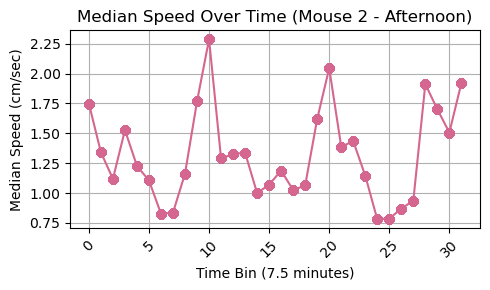

In [66]:
day2_beh_afternoon = video_dfs[3]
day2_beh_afternoon['time'] = day2_beh_afternoon['datetime'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day2_beh_afternoon['time_bin'] = ((day2_beh_afternoon['time'] - day2_beh_afternoon['time'][0]) // 450)
# calculate the median speed for each bin
day2_beh_afternoon['median_speed'] = day2_beh_afternoon.groupby('time_bin')['speed_cm_s'].transform('median')
# plot the median speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day2_beh_afternoon['time_bin'], day2_beh_afternoon['median_speed'], marker='o', linestyle='-',c="#D4668F")
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Median Speed (cm/sec)')
plt.title('Median Speed Over Time (Mouse 2 - Afternoon)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


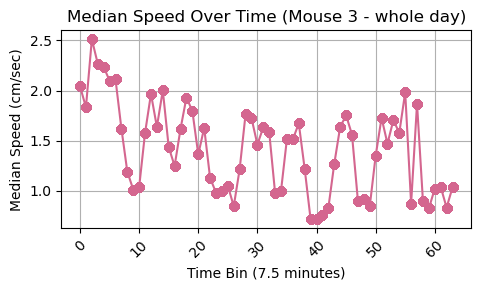

In [68]:
day3_video = video_dfs[4]
# clip to 17:33 (end of microdialysis experiment)
day3_beh = copy.deepcopy(day3_video[day3_video['datetime'] <= '2025-08-25 17:33:00']) # clip to end of microdialysis recording
# # turn everything into seconds
day3_beh['time'] = day3_beh['datetime'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day3_beh['time_bin'] = ((day3_beh['time'] - day3_beh['time'][0]) // 450)
# # calculate the median speed for each bin
day3_beh['median_speed'] = day3_beh.groupby('time_bin')['speed_cm_s'].transform('median')
# plot the median speed for each bin
plt.figure(figsize=(5, 3))
plt.plot(day3_beh['time_bin'], day3_beh['median_speed'], marker='o', linestyle='-',c="#D4668F")
plt.xlabel('Time Bin (7.5 minutes)')
plt.ylabel('Median Speed (cm/sec)')
plt.title('Median Speed Over Time (Mouse 3 - whole day)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# align LCMS and Videos

In [80]:
# select only the unique values of mean speed (in order)
day1_morning_medianspeed = day1_beh_morning['median_speed'].unique()
day1_afternoon_medianspeed = day1_beh_afternoon['median_speed'].unique()
day2_morning_medianspeed = day2_beh_morning['median_speed'].unique()
day2_afternoon_medianspeed = day2_beh_afternoon['median_speed'].unique()
day3_medianspeed = day3_beh['median_speed'].unique()
# print time bins (bc of 0 indexing, add 1) and lengths
print(np.max(day1_beh_morning.time_bin)+1,np.max(day1_beh_afternoon.time_bin)+1,np.max(day2_beh_morning.time_bin)+1,np.max(day2_beh_afternoon.time_bin)+1,np.max(day3_beh.time_bin)+1)
print(len(day1_morning_medianspeed), len(day1_afternoon_medianspeed), len(day2_morning_medianspeed), len(day2_afternoon_medianspeed), len(day3_medianspeed))

25 28 31 32 64
25 28 31 32 64


In [81]:
# Set the delay of LCMS to video to 15 minutes. So 2 bins delay for the hormones in order to be aligned.
X1m = day1_morning[:, 2:-1]  # remove first two samples to align with behavior, and remove last sample
X1a = day1_afternoon[:, 2:]  # remove first two samples to align with behavior
X2m = day2_morning[:, 2:]  # remove first two samples to align with behavior
X2a = day2_afternoon[:, 2:-10]  # remove first two samples to align with behavior, and remove last 10 samples
X3 = day3[:, 2:] # remove first 2 samples

y1m = day1_morning_medianspeed[:-2] # last microdialysis sample pushed out of tubes (see notes) 
y1a = day1_afternoon_medianspeed[:-1] 
y2m = day2_morning_medianspeed[:-1]  # last microdialysis sample pushed out of tubes (see notes)
y2a = day2_afternoon_medianspeed[:-11]  
y3 = day3_medianspeed[:-2]  # remove last two behavior time bins to align with hormones 

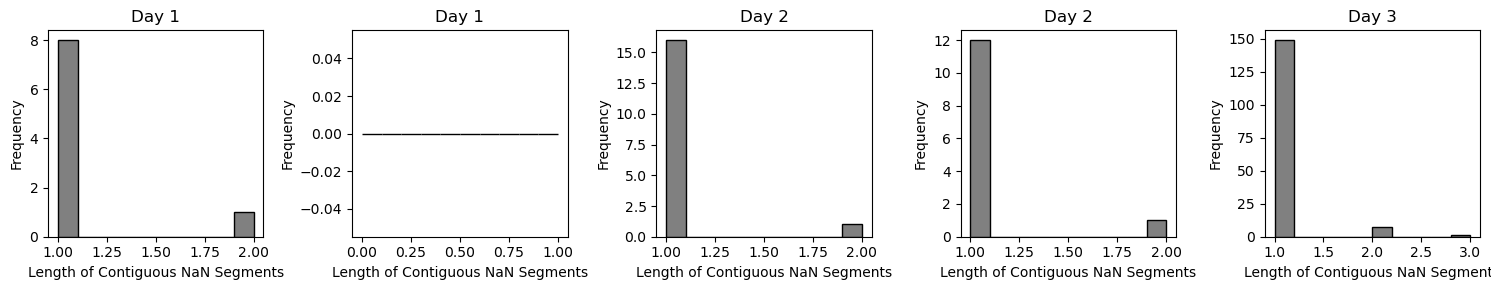

In [82]:
# check for contiguous nan values in each dataset before interpolation
plt.figure(figsize=(15, 3))
for id, dataset in enumerate([X1m, X1a, X2m, X2a, X3]):
    len_nan = []
    for i in range(len(common_compound_names)):
        row = dataset[i,:]
        current_contig_nan = 0
        for val in row:
            if np.isnan(val):
                current_contig_nan += 1
            else:
                if current_contig_nan > 0:
                    len_nan.append(current_contig_nan)
                current_contig_nan = 0
    plt.subplot(1,5,id+1)
    plt.hist(len_nan, color='gray', edgecolor='black')
    plt.xlabel('Length of Contiguous NaN Segments')
    plt.ylabel('Frequency')
    plt.title(f'Day {id//2 +1}')
plt.tight_layout()

In [83]:
# same nan mask
nan_masks = [np.isnan(dataset) for dataset in [X1m, X1a, X2m, X2a, X3]]

# fill nans for X datasets
X1m = np.array([fill_nan_with_interpolation(row) for row in X1m])
X1a = np.array([fill_nan_with_interpolation(row) for row in X1a])
X2m = np.array([fill_nan_with_interpolation(row) for row in X2m])
X2a = np.array([fill_nan_with_interpolation(row) for row in X2a])
X3 = np.array([fill_nan_with_interpolation(row) for row in X3])

In [84]:
# concatenate X1m, pause, and X1a
X1_full = np.hstack((X1m, np.zeros((X1m.shape[0], 10))*np.nan, X1a))
y1_full = np.hstack((y1m, np.zeros(10)*np.nan, y1a))
# concatenate X2m, pause, and X2a
X2_full = np.hstack((X2m, np.zeros((X2m.shape[0], 9))*np.nan, X2a))
y2_full = np.hstack((y2m, np.zeros(9)*np.nan, y2a))

## Figure 1E

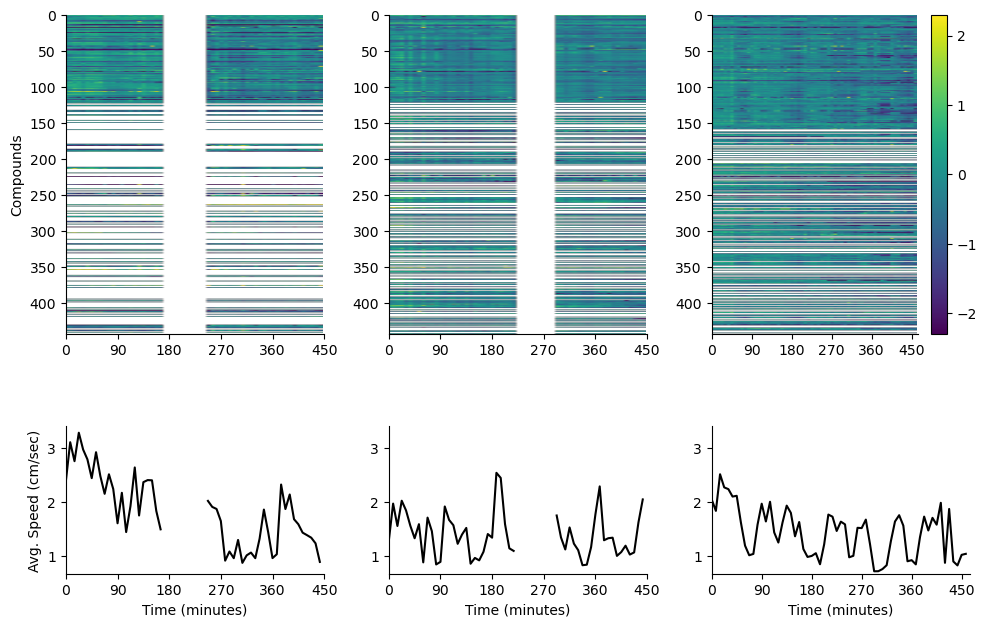

In [85]:
plt.figure(figsize=(10, 8))
anim_comps_speed(X1_full, y1_full, title='Day 1', pos=0)
anim_comps_speed(X2_full, y2_full, title='Day 2', pos=1)
anim_comps_speed(X3, y3, title='Day 3', pos=2)
plt.colorbar()

plt.tight_layout()
plt.savefig('../../figures/fig1/heatmaps_union_compounds_aligned_full.eps', dpi=900)

In [88]:
print(len(common_compound_names))

common_compound_names

123


['(R)-1-Aminopropan-2-ol',
 '1,2-Dihydroxynaphthalene-6-sulfonic acid',
 '1-Methylhistidine',
 '2,6-Dihydroxypyridine',
 '2,8-Dihydroxyadenine',
 '2-Aminooctanoic acid',
 '2-Hydroxy-cis-hex-2,4-dienoic acid',
 '2-Hydroxyethylenedicarboxylic acid',
 '2-Isopropoxyphenol',
 '3-(4-Hydroxyphenyl)lactic acid',
 '3-Amino-2-piperidone',
 '3-Aminoisobutyric acid',
 '3-Hydroxy-L-proline',
 '3-Hydroxybenzaldehyde',
 '3-Methoxy-4-hydroxyphenylacetaldehyde',
 '3-Methylsalicylaldehyde',
 '3-Nitrotyrosine',
 '4,8-Dihydroxyquinoline',
 '4-Amino-2-hydroxylamino-6-nitrotoluene',
 '4-Aminobutyraldehyde',
 '4-Chloro-L-lysine',
 '4-Cresol/3-Cresol',
 '4-Ethylphenol',
 '4-Guanidinobutanal',
 '4-Hydroxybenzaldehyde/3-Hydroxybenzaldehyde',
 '4-Hydroxybenzoic acid',
 '5-Aminopentanal',
 '5-Aminopentanoic acid',
 '5-Hydroxyindoleacetic acid',
 '5-Hydroxylysine',
 'Adenine',
 'Alanine',
 'Alloisoleucine',
 'Allysine',
 'Aminoacetaldehyde',
 'Aminoacrylic acid',
 'Aminoadipic acid',
 'Aniline',
 'Anthranilic acid

In [89]:
# save common compounds aligned with behavior, and list of compound names
L = len(common_compound_names)
np.save('../../data/processed/compounds_aligned_speed.npy', {'X1m':X1m[:L], 'X1a':X1a[:L], 
                                                             'X2m':X2m[:L], 'X2a':X2a[:L], 
                                                             'X3':X3[:L], 'nan_masks':nan_masks,
                                                              'y1m':y1m, 'y1a':y1a, 'y2m':y2m, 'y2a':y2a, 'y3':y3, 
                                                             'common_comps':common_compound_names})